Customer Retention & Cohort Analysis in E-Shop Pro

In [108]:
###IMPORT LIBRARIES 

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date & time handling
from datetime import datetime

# Machine learning & clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Evaluation metrics
from sklearn.metrics import silhouette_score

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [109]:
#Load Data Set
df = pd.read_excel("/Users/bando/Downloads/.venv/bin/Cohort Analysis/Dataset_ecommerce.xlsx")
df.head()

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country
0,536365,2010-12-01 08:26:00,17850.0,SC1734,Electronics,65,10.23,Egypt
1,536365,2010-12-01 08:26:00,17850.0,SC2088,Furniture,95,19.61,Mali
2,536365,2010-12-01 08:26:00,17850.0,SC3463,Books,78,61.49,Mali
3,536365,2010-12-01 08:26:00,17850.0,SC6228,Toys,15,24.73,South Africa
4,536365,2010-12-01 08:26:00,17850.0,SC2149,Toys,50,38.83,Rwanda


Data Cleaning

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   InvoiceDate  541909 non-null  datetime64[ns]
 2   CustomerID   406829 non-null  float64       
 3   StockCode    541909 non-null  object        
 4   Description  541909 non-null  object        
 5   Quantity     541909 non-null  int64         
 6   UnitPrice    541909 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [111]:
#Find Missing Data
df.isnull().sum()

InvoiceNo           0
InvoiceDate         0
CustomerID     135080
StockCode           0
Description         0
Quantity            0
UnitPrice           0
Country             0
dtype: int64

In [112]:
#Remove Missing Data 
df = df.dropna(subset=['CustomerID'])
df.head()

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country
0,536365,2010-12-01 08:26:00,17850.0,SC1734,Electronics,65,10.23,Egypt
1,536365,2010-12-01 08:26:00,17850.0,SC2088,Furniture,95,19.61,Mali
2,536365,2010-12-01 08:26:00,17850.0,SC3463,Books,78,61.49,Mali
3,536365,2010-12-01 08:26:00,17850.0,SC6228,Toys,15,24.73,South Africa
4,536365,2010-12-01 08:26:00,17850.0,SC2149,Toys,50,38.83,Rwanda


In [113]:
#Convert Customer ID from float to string
df['CustomerID'] = df['CustomerID'].astype(float).astype(str)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   InvoiceDate  406829 non-null  datetime64[ns]
 2   CustomerID   406829 non-null  object        
 3   StockCode    406829 non-null  object        
 4   Description  406829 non-null  object        
 5   Quantity     406829 non-null  int64         
 6   UnitPrice    406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.9+ MB


Data Exploration & Feature Engineering

In [115]:
num_customers = df['CustomerID'].nunique()
num_transactions = df['InvoiceNo'].nunique()
num_products = df['StockCode'].nunique()

In [116]:
print(f'Number of Unique Customers {num_customers}')
print(f'Number of Transactions {num_transactions}')
print(f'Number of Products {num_products}')

Number of Unique Customers 4372
Number of Transactions 22190
Number of Products 9000


In [117]:
date_range = (df['InvoiceDate'].min(), df['InvoiceDate'].max())
print(f' Transaction Period: {date_range[0]}, {date_range[1]}')

 Transaction Period: 2010-12-01 08:26:00, 2011-12-09 12:50:00


In [118]:
#Checking for Negative Values in Quantity and Unit Price
print(f'Rows with Negative Quantity: {(df.Quantity <= 0).sum()}')

Rows with Negative Quantity: 0


In [119]:
#Number of Unique Customers by Country
top_countries = df.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False).head()
print(top_countries)

Country
Mozambique      3072
Benin           3054
Togo            3053
Nigeria         3051
Burkina Faso    3049
Name: CustomerID, dtype: int64


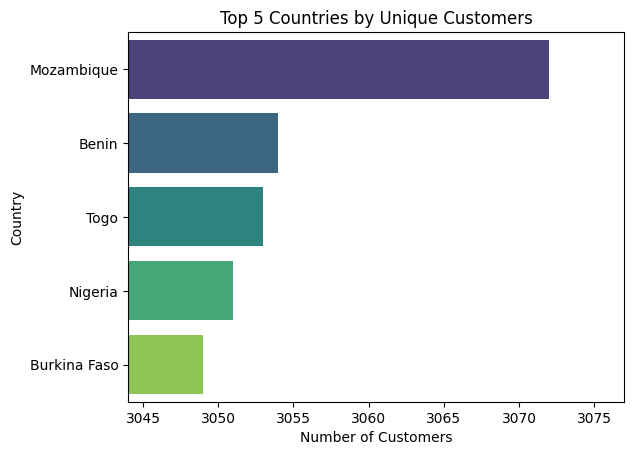

In [ ]:
plt.Figure(figsize=(5,3))
sns.barplot(x= top_countries.values, y=top_countries.index, palette='viridis')
plt.xlim(min(top_countries.values) - 5, max(top_countries.values) + 5)
plt.title('Top 5 Countries by Unique Customers')
plt.xlabel('Number of Customers')
plt.ylabel('Country')
plt.show()

In [121]:
df.head()

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country
0,536365,2010-12-01 08:26:00,17850.0,SC1734,Electronics,65,10.23,Egypt
1,536365,2010-12-01 08:26:00,17850.0,SC2088,Furniture,95,19.61,Mali
2,536365,2010-12-01 08:26:00,17850.0,SC3463,Books,78,61.49,Mali
3,536365,2010-12-01 08:26:00,17850.0,SC6228,Toys,15,24.73,South Africa
4,536365,2010-12-01 08:26:00,17850.0,SC2149,Toys,50,38.83,Rwanda


In [122]:
#Checking Monthly Sales and Revenue
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df['Revenue'] = df['Quantity'] * df['UnitPrice']

In [123]:
monthly_sales = df.groupby('InvoiceMonth')['Revenue'].sum().reset_index()
monthly_sales['InvoiceMonth'] = monthly_sales['InvoiceMonth'].astype(str)
df.head()

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country,InvoiceMonth,Revenue
0,536365,2010-12-01 08:26:00,17850.0,SC1734,Electronics,65,10.23,Egypt,2010-12,664.95
1,536365,2010-12-01 08:26:00,17850.0,SC2088,Furniture,95,19.61,Mali,2010-12,1862.95
2,536365,2010-12-01 08:26:00,17850.0,SC3463,Books,78,61.49,Mali,2010-12,4796.22
3,536365,2010-12-01 08:26:00,17850.0,SC6228,Toys,15,24.73,South Africa,2010-12,370.95
4,536365,2010-12-01 08:26:00,17850.0,SC2149,Toys,50,38.83,Rwanda,2010-12,1941.50


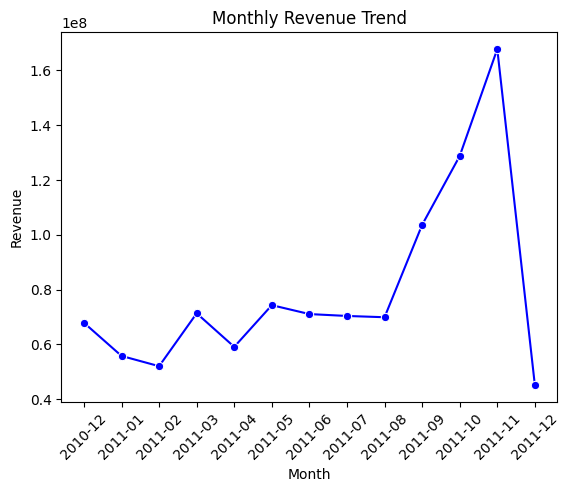

In [124]:
plt.Figure(figsize=(5,3))
sns.lineplot(x='InvoiceMonth', y='Revenue', data=monthly_sales, marker='o', color='blue')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()

Cohort Analysis 

In [125]:
cohort_data = df.groupby('CustomerID')['InvoiceMonth'].min()
cohort_data.name = 'CohortMonth'

cohort_data

CustomerID
12346.0    2011-01
12347.0    2010-12
12348.0    2010-12
12349.0    2011-11
12350.0    2011-02
            ...   
18280.0    2011-03
18281.0    2011-06
18282.0    2011-08
18283.0    2011-01
18287.0    2011-05
Name: CohortMonth, Length: 4372, dtype: period[M]

In [126]:
df = df.merge(cohort_data, on='CustomerID')

In [127]:
df.head()

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country,InvoiceMonth,Revenue,CohortMonth
0,536365,2010-12-01 08:26:00,17850.0,SC1734,Electronics,65,10.23,Egypt,2010-12,664.95,2010-12
1,536365,2010-12-01 08:26:00,17850.0,SC2088,Furniture,95,19.61,Mali,2010-12,1862.95,2010-12
2,536365,2010-12-01 08:26:00,17850.0,SC3463,Books,78,61.49,Mali,2010-12,4796.22,2010-12
3,536365,2010-12-01 08:26:00,17850.0,SC6228,Toys,15,24.73,South Africa,2010-12,370.95,2010-12
4,536365,2010-12-01 08:26:00,17850.0,SC2149,Toys,50,38.83,Rwanda,2010-12,1941.50,2010-12


In [128]:
invoice_year, invoice_month = df['InvoiceMonth'].dt.year, df['InvoiceMonth'].dt.month
cohort_year, cohort_month =  df['CohortMonth'].dt.year, df['CohortMonth'].dt.month

In [129]:
year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

In [130]:
df['CohortIndex'] = year_diff * 12 + month_diff + 1
df.head()

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country,InvoiceMonth,Revenue,CohortMonth,CohortIndex
0,536365,2010-12-01 08:26:00,17850.0,SC1734,Electronics,65,10.23,Egypt,2010-12,664.95,2010-12,1
1,536365,2010-12-01 08:26:00,17850.0,SC2088,Furniture,95,19.61,Mali,2010-12,1862.95,2010-12,1
2,536365,2010-12-01 08:26:00,17850.0,SC3463,Books,78,61.49,Mali,2010-12,4796.22,2010-12,1
3,536365,2010-12-01 08:26:00,17850.0,SC6228,Toys,15,24.73,South Africa,2010-12,370.95,2010-12,1
4,536365,2010-12-01 08:26:00,17850.0,SC2149,Toys,50,38.83,Rwanda,2010-12,1941.50,2010-12,1


In [131]:
df.tail()

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country,InvoiceMonth,Revenue,CohortMonth,CohortIndex
406824,581587,2011-12-09 12:50:00,12680.0,SC5440,Furniture,25,36.53,Mozambique,2011-12,913.25,2011-08,5
406825,581587,2011-12-09 12:50:00,12680.0,SC3576,Cloths,94,90.65,Tunisia,2011-12,8521.10,2011-08,5
406826,581587,2011-12-09 12:50:00,12680.0,SC5283,Furniture,14,40.07,Somalia,2011-12,560.98,2011-08,5
406827,581587,2011-12-09 12:50:00,12680.0,SC1099,Cosmetics,45,79.83,Senegal,2011-12,3592.35,2011-08,5
406828,581587,2011-12-09 12:50:00,12680.0,SC9276,Toys,6,46.62,Ethiopia,2011-12,279.72,2011-08,5


In [132]:
cohort_counts = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()

In [133]:
cohort_pivot = cohort_counts.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_pivot

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0).round(3)
retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.382,0.334,0.387,0.360,0.397,0.380,0.354,0.354,0.395,0.373,0.50,0.274
2011-01,1.0,0.240,0.283,0.242,0.328,0.299,0.261,0.257,0.311,0.347,0.368,0.15,NaN
2011-02,1.0,0.247,0.192,0.279,0.268,0.247,0.255,0.282,0.258,0.313,0.092,NaN,NaN
2011-03,1.0,0.191,0.255,0.218,0.232,0.177,0.264,0.239,0.289,0.089,NaN,NaN,NaN
2011-04,1.0,0.227,0.221,0.211,0.207,0.237,0.231,0.261,0.084,NaN,NaN,NaN,NaN
2011-05,1.0,0.237,0.172,0.172,0.215,0.244,0.265,0.104,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.209,0.187,0.272,0.247,0.336,0.102,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.209,0.204,0.230,0.272,0.115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.251,0.251,0.251,0.138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


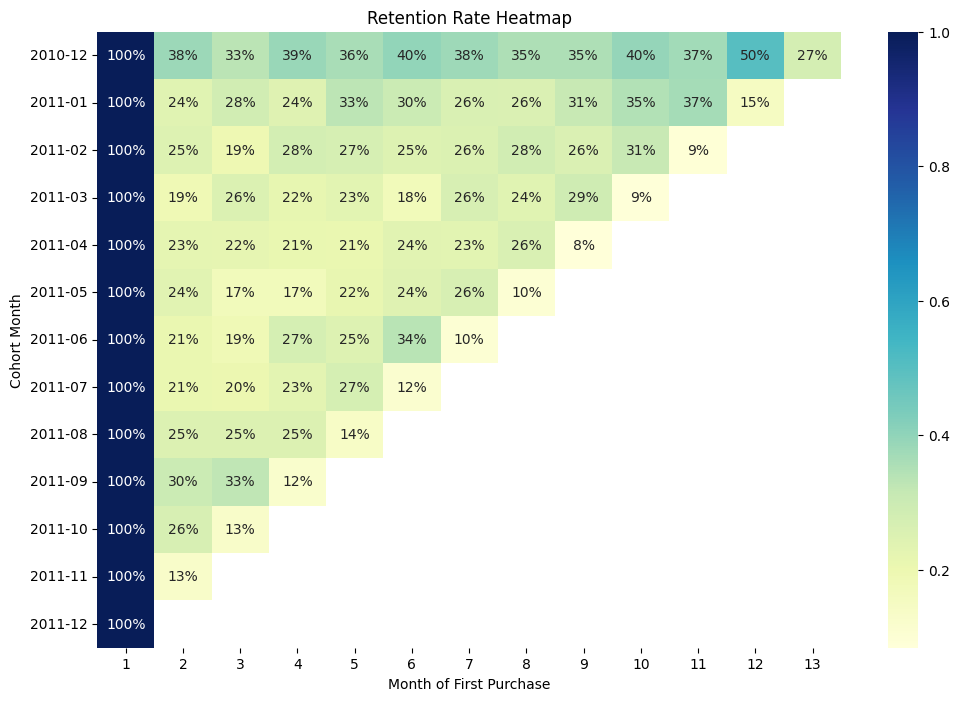

In [135]:
plt.figure(figsize=(12,8))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='YlGnBu')
plt.title('Retention Rate Heatmap')
plt.xlabel('Month of First Purchase')
plt.ylabel('Cohort Month')
plt.show()

In [136]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
reference_date

Timestamp('2011-12-10 12:50:00')

In [137]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': pd.Series.nunique,
    'Revenue': "sum"
}).reset_index()
rfm.head()

,CustomerID,InvoiceDate,InvoiceNo,Revenue
0,12346.0,326,2,5342.40
1,12347.0,2,7,431501.00
2,12348.0,75,4,82378.47
3,12349.0,19,1,176075.12
4,12350.0,310,1,48173.37


In [138]:
rfm.describe()

,InvoiceDate,InvoiceNo,Revenue
count,4372.000000,4372.000000,4.372000e+03
mean,92.047118,5.075480,2.372909e+05
std,100.765435,9.338754,5.944603e+05
min,1.000000,1.000000,1.736000e+01
25%,17.000000,1.000000,4.350893e+04
50%,50.000000,3.000000,1.066925e+05
75%,143.000000,5.000000,2.599154e+05
max,374.000000,248.000000,2.038383e+07


In [139]:
rfm.columns = ['CustomerID', 'recency_days', 'frequency', 'monetary']

In [140]:
X = rfm[['recency_days', 'frequency', 'monetary']].copy()

In [141]:
from sklearn.preprocessing import StandardScaler

In [142]:
ss = StandardScaler()

In [143]:
X_scaled = ss.fit_transform(X)

In [144]:
X_scaled[:5]

array([[ 2.32202285, -0.32936215, -0.39022789],
       [-0.89373323,  0.20610242,  0.32673724],
       [-0.1691956 , -0.11517632, -0.26062315],
       [-0.72500529, -0.43645506, -0.1029888 ],
       [ 2.16322008, -0.43645506, -0.31816948]])

In [145]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [146]:
inertia = []
s_score = []
K_range = range(2,11)

In [147]:
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    s_score.append(silhouette_score(X_scaled, labels))

In [159]:
inertia

[9046.078478815765,
 5336.966767083279,
 3523.5663091538927,
 2838.8802535207556,
 2324.062624515256,
 1879.2757377823086,
 1646.4006901120968,
 1489.4757907270555,
 1323.1187606006401]

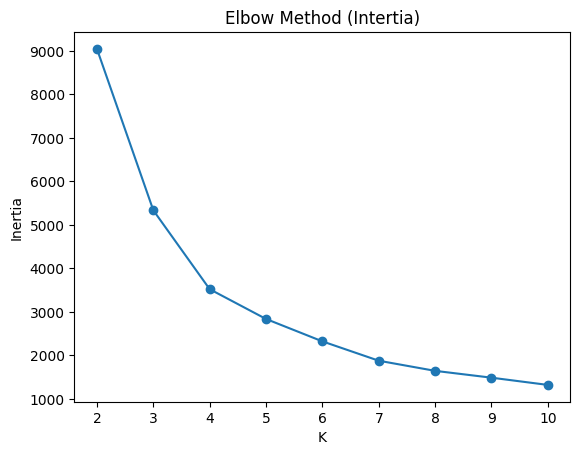

In [157]:
plt.Figure(figsize=(3,3))
plt.subplot(1, 1, 1)
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method (Intertia)')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.tight_layout
plt.show()

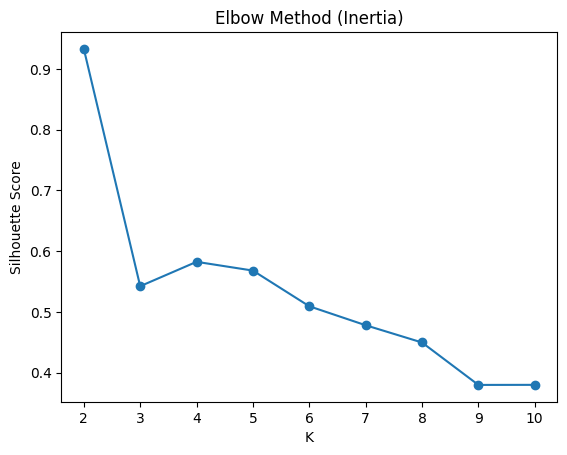

In [158]:
plt.Figure(figsize=(12,4))
plt.subplot(1, 1, 1)
plt.plot(K_range, s_score, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.tight_layout
plt.show()

In [154]:
!pip install yellowbrick

In [160]:
from yellowbrick.cluster import KElbowVisualizer

,estimator,KMeans(n_clus...ndom_state=42)
,ax,<Axes: >
,k,"(2, ...)"
,metric,'distortion'
,distance_metric,'euclidean'
,timings,True
,locate_elbow,True
,n_clusters,9
,init,'k-means++'
,n_init,'auto'
,max_iter,300


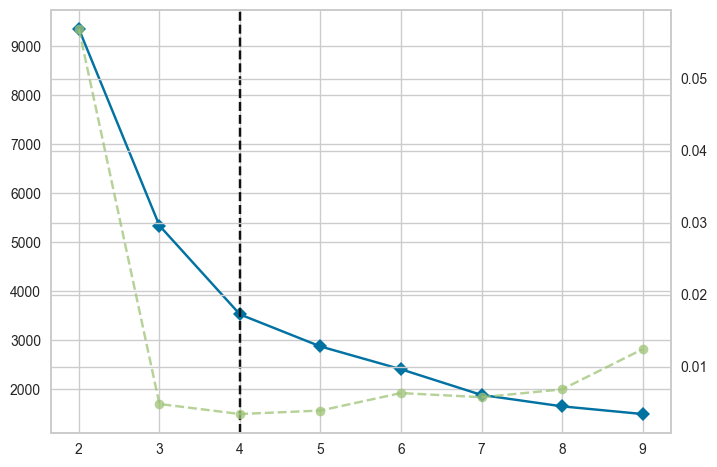

In [161]:
model = KMeans(random_state=42)
v = KElbowVisualizer(model, k=(2,10))
v.fit(X_scaled)

In [162]:
final_k = 4
final_model = KMeans(n_clusters=final_k, random_state=42)

In [163]:
final_model.fit(X_scaled)

,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [164]:
rfm.head()

,CustomerID,recency_days,frequency,monetary
0,12346.0,326,2,5342.40
1,12347.0,2,7,431501.00
2,12348.0,75,4,82378.47
3,12349.0,19,1,176075.12
4,12350.0,310,1,48173.37


In [165]:
rfm['Cluster'] = final_model.labels_

In [166]:
rfm.head()

,CustomerID,recency_days,frequency,monetary,Cluster
0,12346.0,326,2,5342.40,1
1,12347.0,2,7,431501.00,0
2,12348.0,75,4,82378.47,0
3,12349.0,19,1,176075.12,0
4,12350.0,310,1,48173.37,1


In [171]:
cluster_profile = rfm.groupby('Cluster').agg({
    'recency_days':'mean',
    'frequency':'mean',
    'monetary':'mean',
    'CustomerID':'count'
}).rename(columns = {'CustomerID': 'NumCustomers'}).round(1)

In [172]:
cluster_profile

,recency_days,frequency,monetary,NumCustomers
Cluster,,,,
0,43.4,4.2,195421.0,3023
1,248.9,1.8,69191.6,1077
2,1.7,153.5,12345024.6,6
3,11.8,25.3,1120633.6,266


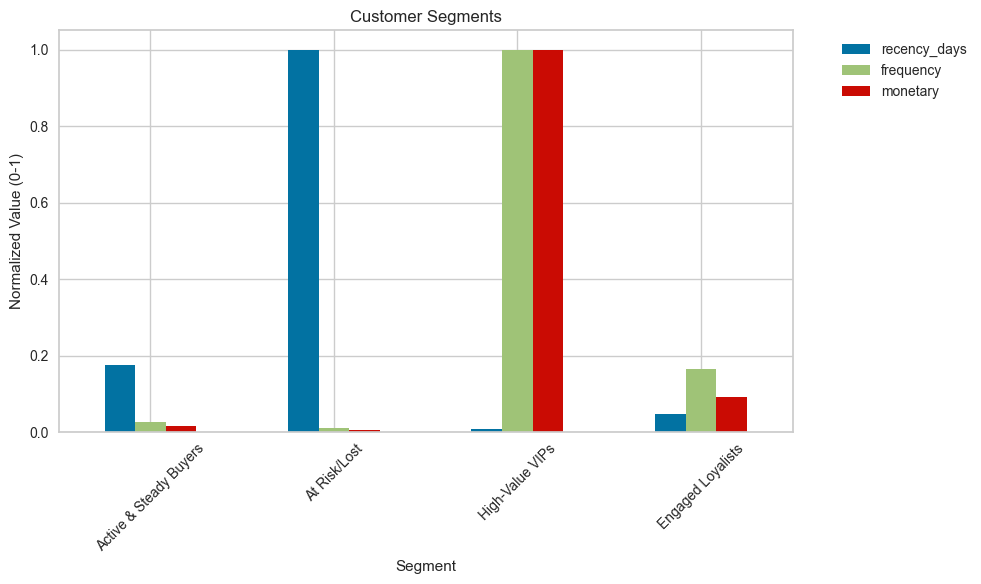

In [176]:
cluster_names = {
    0: 'Active & Steady Buyers',
    1: 'At Risk/Lost',
    2: 'High-Value VIPs',
    3: 'Engaged Loyalists'
}

cluster_profile['Segment'] = cluster_profile.index.map(cluster_names)

df_plot = cluster_profile.copy()
df_plot[['recency_days', 'frequency', 'monetary']] = (
    df_plot[['recency_days', 'frequency', 'monetary']]
    .apply(lambda x: x/x.max())
)

df_plot.set_index('Segment')[['recency_days', 'frequency', 'monetary']].plot(
    kind='bar', figsize=(10,6)
)
plt.title('Customer Segments')
plt.ylabel('Normalized Value (0-1)')
plt.xticks(rotation = 45)
plt.legend(['recency_days', 'frequency', 'monetary'], bbox_to_anchor= (1.05, 1), loc = 'upper left')
plt.tight_layout()
plt.show()

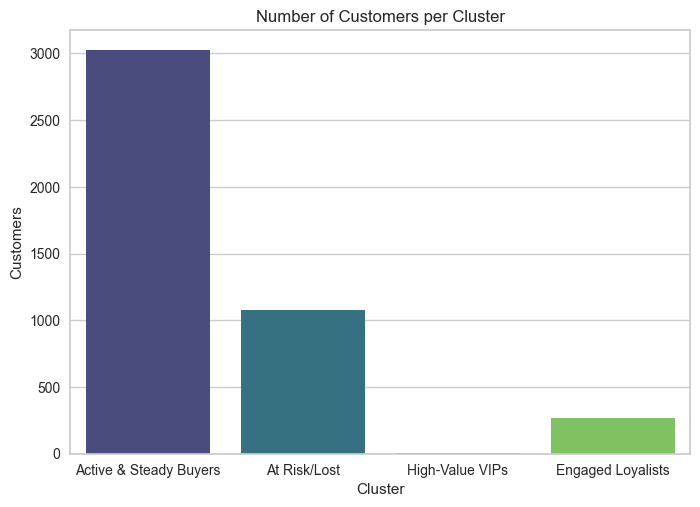

In [181]:
plt.Figure(figsize = (10, 3))
sns.barplot(x= cluster_names, y=cluster_profile.NumCustomers, palette='viridis')
plt.title('Number of Customers per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Customers')
plt.show()

In [182]:
High_value_vips = rfm[rfm['Cluster'] == 2].copy()

In [183]:
High_value_vips

,CustomerID,recency_days,frequency,monetary,Cluster
330,12748.0,1,224,11912482.34,2
1300,14096.0,4,34,12965429.74,2
1674,14606.0,1,128,7144512.92,2
1895,14911.0,1,248,15362741.47,2
2192,15311.0,1,118,6301150.63,2
4042,17841.0,2,169,20383830.65,2


In [187]:
customer_cohort = df[['CustomerID', 'CohortMonth']].drop_duplicates()

In [188]:
cluster2_customers = High_value_vips.merge(customer_cohort, on='CustomerID', how='left')

In [189]:
cluster2_customers

,CustomerID,recency_days,frequency,monetary,Cluster,CohortMonth
0,12748.0,1,224,11912482.34,2,2010-12
1,14096.0,4,34,12965429.74,2,2011-08
2,14606.0,1,128,7144512.92,2,2010-12
3,14911.0,1,248,15362741.47,2,2010-12
4,15311.0,1,118,6301150.63,2,2010-12
5,17841.0,2,169,20383830.65,2,2010-12
